# PIP-PRoS: Predição da trajetória da bola

Neste notebook o algoritmo de predição da trajetória da bola para realizar seu bloqueio é descrito passo a passo. O Algoritmo usa um filtro de Kalman para realizar o cálculo da velocidade da bola e com isso calcular sua trajetória.

Para mais informações, acesse [o site do projeto](https://sites.google.com/tecnico.ulisboa.pt/pip-pros/)!

## Bibliotecas utilizadas

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Abaixo está a função de detecção da bola, que será usada mas não descrita neste notebook. Sua explicação detalhada se encontra no notebook correspondente.

In [24]:
ball_hsv_lower = (0, 80, 0)
ball_hsv_upper = (20, 250, 200)

minimum_ball_area = 300
maximum_ball_area = 3000

def detect_ball(frame, output_frame):
    # First we blur the image with a GaussianBlur
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    
    # Construct a HSV mask for the green color
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, ball_hsv_lower, ball_hsv_upper)

    # Erode and dilate the result to remove small noises
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # Then we calculate the countours of the resulting image
    frame_cnts, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(output_frame, frame_cnts, -1, (0,0,255), 2)

    if len(frame_cnts) == 0:
        return False, output_frame, [], -1, -1, -1

    # Calculate the circularity of the identified countours
    areas = np.array([cv2.contourArea(c) for c in frame_cnts])
    is_reading_valid = (areas > minimum_ball_area) & (areas < maximum_ball_area)

    if np.sum(is_reading_valid) == 0:
        return False, output_frame, [], -1, -1, -1

    perimeters = np.array([cv2.arcLength(c,True) for c in frame_cnts])

    circularities = 4 * np.pi * areas/(perimeters**2)
    circularities = circularities*is_reading_valid
    ball_cnt_idx = np.argmax(circularities)
    # We get the one with the greatest circularity (4*pi*area/(perimeter^2))
    # https://www.mathworks.com/help/images/identifying-round-objects.html
    c = frame_cnts[ball_cnt_idx]
    # And calculate the minimum enclosing circle
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    
    # Calculate the shape
    approx = cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True)

    # If the shape is really close to a circle and the area is greater than the minimum
    # the contour is considered to be the ball
    if (len(approx) > 5) & (len(approx) < 23):
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        cv2.circle(output_frame, (int(x), int(y)), int(radius), (0, 255, 0), 2)

        return True, output_frame, frame_cnts, x, y, radius
    return False, output_frame, [], -1, -1, -1

In [25]:
# Configuring the ArUco detector
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
parameters =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

def calculate_perspective_transform(frame):
	# First we make the image monochromatic
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	# Then we detect the arucos
	corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
	frame_markers = cv2.aruco.drawDetectedMarkers(frame.copy(), corners, ids)
	corners = np.array(corners, dtype=int)

	# We now check if the amount of detected ArUcos is the expected one
	# If it is not, the detection failed
	if len(corners) == 4:		
		field_delimited = True
		# The top left corner is identified by the Aruco with ID = 0
		top_left_corner_id = np.where(ids == 0)[0][0]

		# The bottom right corner is identified by the Aruco with ID = 2
		bottom_right_corner_id = np.where(ids == 2)[0][0]

		# The bottom right corner is identified by the Aruco with ID = 3
		top_right_corner_id = np.where(ids == 3)[0][0]

		# The bottom right corner is identified by the Aruco with ID = 1
		bottom_left_corner_id = np.where(ids == 1)[0][0]

		top_left_corner = corners[top_left_corner_id][0][0]
		bottom_right_corner = corners[bottom_right_corner_id][0][0]
		top_right_corner = corners[top_right_corner_id][0][0]
		bottom_left_corner = corners[bottom_left_corner_id][0][0]

		width_top = np.hypot(
			top_left_corner[0] - top_right_corner[0], 
			top_left_corner[1] - top_right_corner[1])
		width_bottom = np.hypot(
			bottom_left_corner[0] - bottom_right_corner[0], 
			bottom_left_corner[1] - bottom_right_corner[1])
		max_width = max(int(width_top), int(width_bottom))

		height_left = np.hypot(
			top_left_corner[0] - bottom_left_corner[0], 
			top_left_corner[1] - bottom_left_corner[1])
		height_right = np.hypot(
			top_right_corner[0] - bottom_right_corner[0], 
			top_right_corner[1] - bottom_right_corner[1])
		max_height = max(int(height_left), int(height_right))

		input_pts = np.float32([top_left_corner, 
								bottom_left_corner, 
								bottom_right_corner, 
								top_right_corner])
		output_pts = np.float32([[0, 0],
								[0, max_height - 1],
								[max_width - 1, max_height - 1],
								[max_width - 1, 0]])

		# Compute the perspective transform M
		M = cv2.getPerspectiveTransform(input_pts,output_pts)
		_, IM = cv2.invert(M)

		return M, IM, max_width, max_height


## Vídeo utilizado como exemplo

<video alt="Example video" controls style="max-width:500px">
    <source src="../assets/examples/trajectory.mp4" type="video/mp4">
</video>

(540, 811, 3)


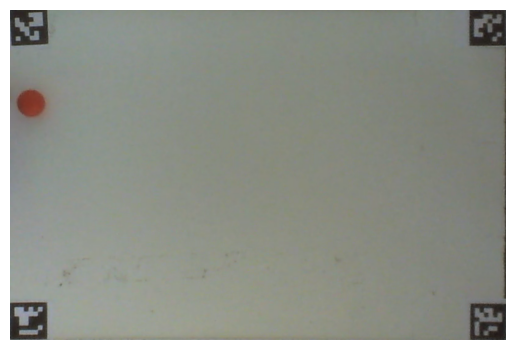

In [26]:
vid_capture = cv2.VideoCapture('../assets/examples/trajectory.mp4')

_, frame = vid_capture.read()
M, IM, max_width, max_height = calculate_perspective_transform(frame)

# Jumping to part of interest of the video
for _ in range(21):
    _, frame = vid_capture.read()

frame = cv2.warpPerspective(frame,M,(max_width, max_height),flags=cv2.INTER_LINEAR)
print(frame.shape)
plt.axis("off")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Cálculo da direção de movimento da bola

O Filtro de Kalman é um algoritmo de estimativa utilizado em aplicações de visão computacional para calcular a velocidade de objetos. Ele combina medições de sensores com um modelo dinâmico do sistema para estimar o estado atual, considerando ruídos e incertezas. Ao prever o estado futuro do objeto e atualizá-lo com base em medições reais, o filtro aprimora a estimativa da velocidade ao longo do tempo, proporcionando resultados mais precisos para o rastreamento de objetos e análise de movimento na presença de ruído nos sensores. Será utilizada a implementação de [Kalman Filter do próprio OpenCV](https://docs.opencv.org/3.4/dd/d6a/classcv_1_1KalmanFilter.html#details).


O filtro instanciado terá 4 variáveis, que modelam a posição da bola e sua direção de movimento - $x, y, \Delta x, \Delta y$ - no entanto apenas as primeiras duas podem ser medidas diretamente pelo processamento da imagem (pela detecção da posição da bola vista anteriormente).

Dessa forma, a matriz de medição será dada por:

$$ 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1& 0 & 0 
\end{bmatrix}
$$

A matriz de transição, por sua vez, dita como as variáveis evoluem a cada iteração. Dessa forma, como $x_{n+1} = x_n + \Delta x_n$ e assumindo velocidade constante para a bola após lançamento, é possível obter a seguinte matriz de transição:

$$ 
\begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$


In [27]:
kf = cv2.KalmanFilter(4, 2)
kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kf.transitionMatrix = np.array(
    [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32
)

Com o filtro instanciado é possível incorporar as medições realizadas por meio do método ```kf.correct``` para um posterior cálculo do estado estimado do sistema, pelo ```kf.predict```. 

O código abaixo itera, sobre os 20 primeiros frames do vídeo, esse processo. Os estados observados pelo filtro são guardados para posterior análise.

In [28]:
x_array = []
y_array = []
xd_array = []
yd_array = []

for _ in range(20):
    _, frame = vid_capture.read()
    frame = cv2.warpPerspective(frame,M,(max_width, max_height),flags=cv2.INTER_LINEAR)
    
    is_ball_detected, _, _, x, y, radius = detect_ball(frame, frame)
    
    if is_ball_detected:
        kf.correct(np.array([x, y], dtype=np.float32))
        _, _, xd_pred, yd_pred = kf.predict()

        if xd_pred and yd_pred:
            x_array.append(x)
            y_array.append(y)
            xd_array.append(xd_pred)
            yd_array.append(yd_pred)

Na Figura montada abaixo é possível ver de forma gráfica os pontos em que a bola foi detectada e o deslocamento calculado pelo filtro de Kalman.

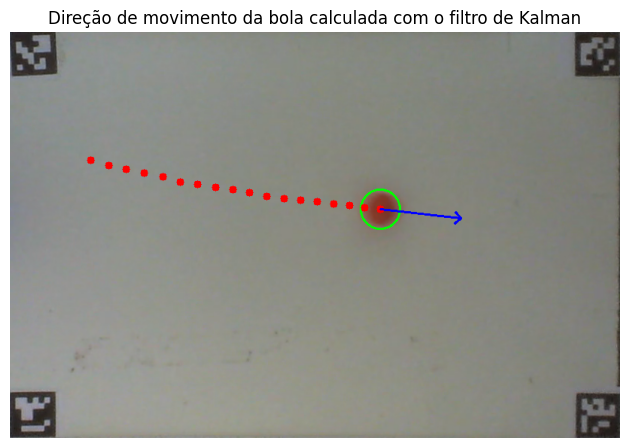

In [29]:
xd = np.mean(xd_array[-5:])
yd = np.mean(yd_array[-5:])

img = frame.copy()

for x_t, y_t in zip(x_array, y_array):
    cv2.circle(img, (int(x_t), int(y_t)), radius=5, color=(0, 0, 255), thickness=-1)
cv2.arrowedLine(img, (int(x), int(y)), (int(x+5*xd), int(y+5*yd)), (255, 0, 0), 2) 

plt.axis("off")
plt.title("Direção de movimento da bola calculada com o filtro de Kalman")
plt.tight_layout()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Com essa informação sobre a direção da bola e tendo em conta as dimensões do campo, é possível encontrar o ponto em que a bola interceptará o outro lado do campo por simples relações trigonométricas.

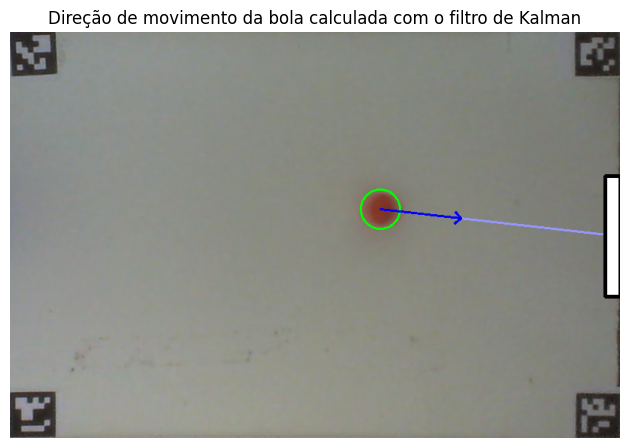

In [30]:
img = frame.copy()

slope = yd/xd
motor_setpoint = slope*(max_width - x) + y

predict_line_color = (255, 150, 150)
img = cv2.line(img, (int(x), int(y)), (int(max_width), int(motor_setpoint)), predict_line_color, 2)
cv2.arrowedLine(img, (int(x), int(y)), (int(x+5*xd), int(y+5*yd)), (255, 0, 0), 2) 
img = cv2.rectangle(img, (int(max_width - 20), int(motor_setpoint - 80)), (int(max_width), int(motor_setpoint + 80)), color=(255, 255, 255), thickness=-1)
img = cv2.rectangle(img, (int(max_width - 20), int(motor_setpoint - 80)), (int(max_width), int(motor_setpoint + 80)), color=(0, 0, 0), thickness=3)

plt.axis("off")
plt.title("Direção de movimento da bola calculada com o filtro de Kalman")
plt.tight_layout()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Reflexões da bola nas paredes do campo

De forma a levar em conta as colisões da bola com a parede no cálculo da trajetória, todos os choques foram considerados como perfeitamente elásticos de forma que os ângulos de incidência e de reflexão são iguais. 

A lógica usada para o cálculo das reflexões é simples. Inicialmente calcula-se a posição final esperada como anteriormente. Caso esteja fora do campo é calculada a distância entre essa posição e o campo. O número de reflexões será dado pelo teto da divisão entre essa distância e a largura do campo. 

Tendo calculado o número de reflexões que a bola irá realizar até chegar à extremidade final do campo é possível calcular a posição final da bola.

In [31]:
empty_field_frame = cv2.imread('../assets/examples/empty_field.png')

Número de reflexões: 2


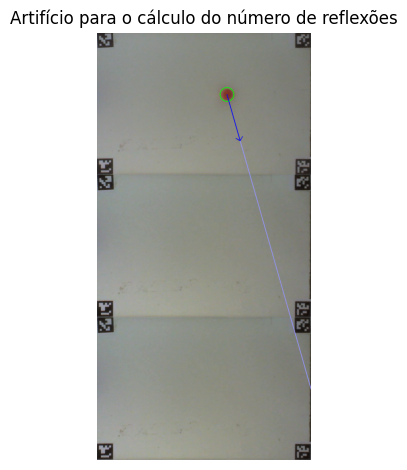

In [32]:
img = frame.copy()
img = np.vstack((img, empty_field_frame, empty_field_frame))

xd = 10
yd = 35
slope = yd/xd
motor_setpoint = slope*(max_width - x) + y

# Se a predição houver ultrapassado o campo pelo limite inferior
# é calculado o número de reflexões da trajetória
if motor_setpoint > max_height:
    distance_from_prediction_to_field = abs(max_height - motor_setpoint)
    number_of_refletions = np.ceil(distance_from_prediction_to_field / max_height).astype(int)
    print("Número de reflexões:", number_of_refletions)

img = cv2.line(img, (int(x), int(y)), (int(max_width), int(motor_setpoint)), (255, 150, 150), 2)
cv2.arrowedLine(img, (int(x), int(y)), (int(x+5*xd), int(y+5*yd)), (255, 0, 0), 2) 

plt.axis("off")
plt.title("Artifício para o cálculo do número de reflexões")
plt.tight_layout()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

A imagem acima mostra a posição final prevista caso o campo se estendesse. É possível entender o conjunto de reflexões como uma sobreposição dos movimentos que a bola faz em cada um desses "campos" vistos na imagem, ora espelhados, ora não. 

No campo original a bola faz um primeiro movimento até a primeira aresta. Após passar para o segundo campo, na realidade o movimento é espelhado dentro do primeiro campo na direção da outra aresta. Por último, o movimento no terceiro "campo" pode ser apenas sobreposto no campo original, já que o movimento espelhado é espelhado novamente.

Na imagem a seguir é possível ver essa dinâmica, que gera ao final a trajetória completa da bola.

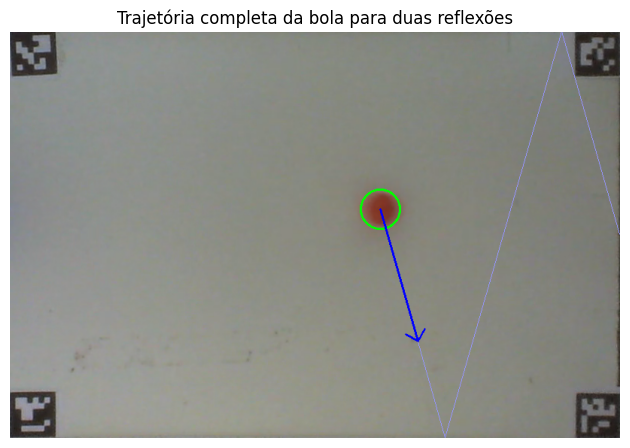

In [34]:
img = frame.copy()

current_x = x
next_x = x
current_y = y
next_y = y
for n in range(1, number_of_refletions + 1):
    if n % 2 == 1:
        next_x = (max_height - current_y)/slope + current_x
        next_y = max_height
        cv2.line(img, (int(current_x), int(current_y)), (int(next_x), max_height), (255, 150, 150), 1)     
    if n % 2 == 0:
        next_x = current_y/slope + current_x
        next_y = 0
        cv2.line(img, (int(current_x), int(current_y)), (int(next_x), 0), (255, 150, 150), 1)     
    current_x = next_x
    current_y = next_y

if (number_of_refletions % 2 == 1):
    motor_setpoint = max_height - distance_from_prediction_to_field % max_height
    
if (number_of_refletions % 2 == 0):
    motor_setpoint = distance_from_prediction_to_field % max_height

cv2.line(img, (int(current_x), int(current_y)), (int(max_width), int(motor_setpoint)), (255, 150, 150), 1)     
cv2.arrowedLine(img, (int(x), int(y)), (int(x+5*xd), int(y+5*yd)), (255, 0, 0), 2) 

plt.axis("off")
plt.title("Trajetória completa da bola para duas reflexões")
plt.tight_layout()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))